## Hand-written Digit Classification using feature-based linear regression  
EECS 551, F19  <br>
2018-10-02 Jeff Fessler and Steven Whitaker <br>
2019-10-04 modified by Caroline Crockett

### Overview
This task illustrates how to classifying handwritten digits
using linear regression based on "hand crafted" features.
We focus on just the two digits "0" and "1" although the principles generalize to all digits.

In [59]:
# packages needed
using Plots
using Statistics: mean
using LinearAlgebra

### Task 0: load the data and look at it

In [60]:
# Read the MNIST data file for 0 and 1 digits
# Download from web if needed
file0 = "data0"
file1 = "data1"
if !isfile(file0)
    download("http://cis.jhu.edu/~sachin/digit/data0", file0)
end
if !isfile(file1)
    download("http://cis.jhu.edu/~sachin/digit/data1", file1)
end

nx = 28 # Original image size
ny = 28
nrep = 1000

d0 = Array{UInt8}(undef, (nx,ny,nrep))
read!(file0, d0) # load images of 0 digits

d1 = Array{UInt8}(undef, (nx,ny,nrep))
read!(file1, d1) # load images of 1 digits

iy = 2:ny
d0 = d0[:,iy,:] # Make images non-square to help debug
d1 = d1[:,iy,:]
ny = length(iy)

# Convert images to Float32 to avoid overflow errors
d0 = Array{Float32}(d0)
d1 = Array{Float32}(d1)

display(size(d0))

(28, 27, 1000)

In [79]:
# Function to display mosaic of multiple images
imshow3 = (x) -> begin
    tmp = permutedims(x, [1, 3, 2])
    tmp = reshape(tmp, :, ny)
    heatmap(1:size(tmp,1), 1:ny, transpose(tmp),
        xtick=[1,nx], ytick=[1,ny], yflip=true,
        color=:grays, aspect_ratio=1)
end

#39 (generic function with 1 method)

In [62]:
# Use some data for training, and some for testing
ntrain = 100
ntest = nrep - ntrain
train0 = d0[:,:,1:ntrain] # Training data
train1 = d1[:,:,1:ntrain]
test0 = d0[:,:,(ntrain+1):end] # Testing data
test1 = d1[:,:,(ntrain+1):end];

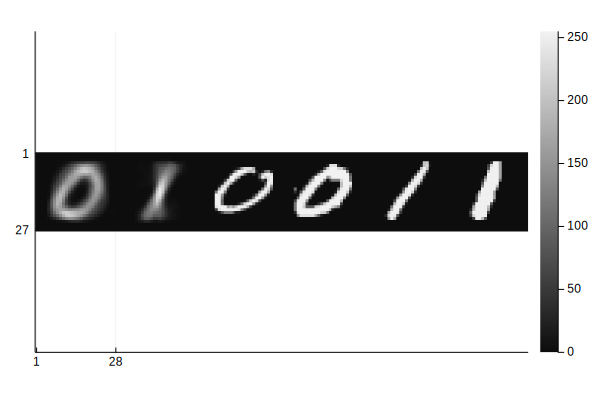

In [63]:
# Look at mean image from each class and a couple of the images just to get a sense of things
# You do not need to include this picture in your report

mean0 = mean(train0, dims = 3)
mean1 = mean(train1, dims = 3)

imshow3(cat(mean0, mean1, d0[:,:,50:51], d1[:,:,601:602], dims = 3))

In [64]:
savefig("tmp0.pdf")

### Task 1

The first real task here is to write a function that extracts features from digit images so that you can then use those features for classification.  Here you are going to use two "hand-crafted" features: the mean of the image, and the mean of the middle column of the image. In addition to these two features, for classification by linear regression we usually include the constant ```1``` as a feature as well.  So we have a total of 3 features.  

Write a function named ```data_to_features``` that takes as input a stack of images, i.e., a data array of size ```[nx,ny,n]```, where ```n``` is the number of images in the stack, and returns the features for each image in the stack.  The output has size ```[n,3]``` where the first column is the mean of each image, the 2nd column is the middle-column-mean of each image, and the third column is the ```1``` feature. 

Julia hints: <br> 
If ```d``` denotes a $N_x \times N_y$ image, then ```d[Nx/2,:]``` is the middle column. <br> 
Use the ```mean``` function to compute the mean. <br>
Try ```Nx=10``` and ```typeof(Nx)``` and ```Nx/2``` and ```typeof(Nx/2)```. <br>  

In [65]:
# function template  
function data_to_features(data) # data is [nx,ny,n]
    nx = size(data,1)  #nx = 28
    ny = size(data,2)  #ny = 27
    n = size(data,3)   #n = 100
    features = zeros(n,3)
    for k = 1:n
        features[k,1] = mean(data[:,:,k])
        features[k,2] = mean(data[14,:,k])
        features[k,3] = 1   
    end
    return features # should be [n,3] 
end

data_to_features (generic function with 1 method)

Include the code for your  ```data_to_features``` function in your write-up.

The next code block extracts the features from the training images and shows them as a scatter plot.  
Think about these questions for yourself:  
Does it look like the two classes of digits are well separated? 
If you drew a line "between" the classes, roughly what classification accuracy would you expect to get?   
Include this scatter plot in your report as the end of task 1.

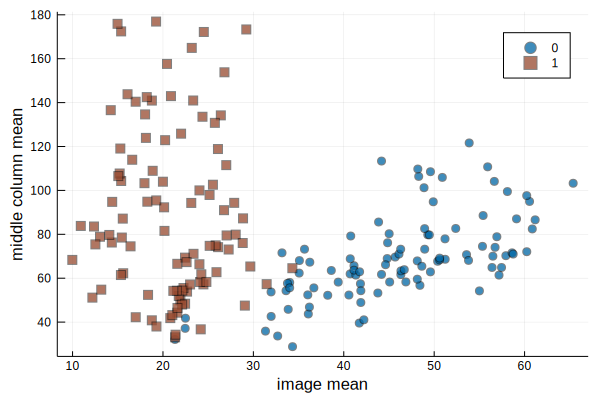

In [66]:
# scatter plot of two features, colored with digit labels

A0 = data_to_features(train0)
A1 = data_to_features(train1)

ps = scatter(A0[:,1], A0[:,2], marker=:circle, label="0", alpha=0.5)
scatter!(ps, A1[:,1], A1[:,2], marker=:square, label="1", alpha=0.5)
scatter!(ps, xlabel="image mean", ylabel="middle column mean")

In [67]:
savefig("tmp1.pdf")

### Task 2

Solve an appropriate linear least-squares (LLS) problem
to determine the regression coefficients $x$
that allow us you to predict the class of a digit from the features.
There are three features so $x$ is a vector of length 3.
For the LS cost function $|A x - y|^2$
let $y_i$ be -1 for the 0 digits and +1 for the 1 digits.
Determine the best $x$

In [68]:
# student template for least-squares based regression
 A = [A0;A1]
 y0 = ones(size(A0))
 y0 = -1 * y0
 y1 = ones(size(A1))
 y = [y0;y1]
 x = pinv(A)*y
 x = x[:,1]

3-element Array{Float64,1}:
 -0.0572202871818437
  0.005793516115525 
  1.4558566338140002

Copy your values of ```x``` into your report.  
If you have done this step correctly,
then the first element of ```x``` i.e., ```x[1]```, will be negative.  
Explain briefly in your report why it is negative.  
Ask for help if your value is not negative!  
Optional: think about why $|x_2| \ll |x_1|$.  
  
Next we add a line to the plot that roughly separates the two classes
(if you did everything correctly).  
Get help if the line does not appear or does not separate the classes.  
Include this figure with the line in your report.  

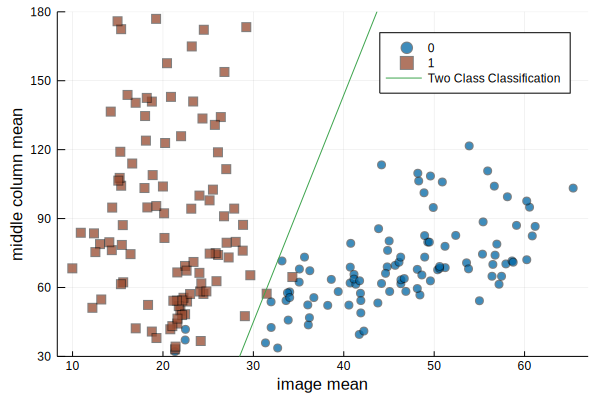

In [69]:
# Draw a line on the above plot based on x
a1 = LinRange(20,50,100)
a2 = -(x[3]/x[2] .+ x[1]/x[2]*a1)
plot!(ps, a1, a2, ylim=(30,180), label="Two Class Classification")

### Task 3

Now we are going to prepare to classify the *test* data
using the hand-crafted features
and our linear regression coefficient vector $x$.
If ```a``` denotes a row vector with the 3 features,
then ```y = a * x``` is our predicted value
and if ```y``` is negative then probably it is a 0 digit
and if ```y``` is positive the probably it is a 1 digit.  

Compute a variable ```ytest0```
that is a vector of length ```ntest```
that is the predicted $y$ value
for each of the test "0" images.
This can be done with one line of code!
Likewise,
compute a variable ```ytest1```
for each of the test "1" images.

In [71]:
# template
#A0_t = transpose(A0)
#A1_t = transpose(A1)
A0_test = data_to_features(test0)
A1_test = data_to_features(test1)
ytest0 = A0_test[:,1] * x[1] + A0_test[:,2] * x[2] + A0_test[:,3] * x[3]
ytest1 = A1_test[:,1] * x[1] + A1_test[:,2] * x[2] + A1_test[:,3] * x[3] 

900-element Array{Float64,1}:
 0.4727474018736084  
 0.4415626953686598  
 0.9997391285228544  
 0.5821343470349922  
 0.5639899712382213  
 0.5161180521808756  
 0.385878901764237   
 0.5031423735306011  
 0.8121141636733904  
 0.8444376254656429  
 0.5611140983093768  
 0.016125362424555423
 0.7562351181014872  
 ⋮                   
 0.855920496520915   
 0.9272681675493055  
 0.7212668670512252  
 0.18934874509744204 
 0.732571960930755   
 0.5239190686287739  
 0.48257330315392366 
 0.4798414099632351  
 1.106876717839857   
 0.7360630323845061  
 0.3522574058241674  
 1.2166839107787066  

Next we make a historam plot of these predicted values to see how well we have separated the two classes.  Your histograms should look somewhat like the two overlapping distributions in this picture: 
https://en.wikipedia.org/wiki/Receiver_operating_characteristic#/media/File:ROC_curves.svg

Include your histogram in your report.

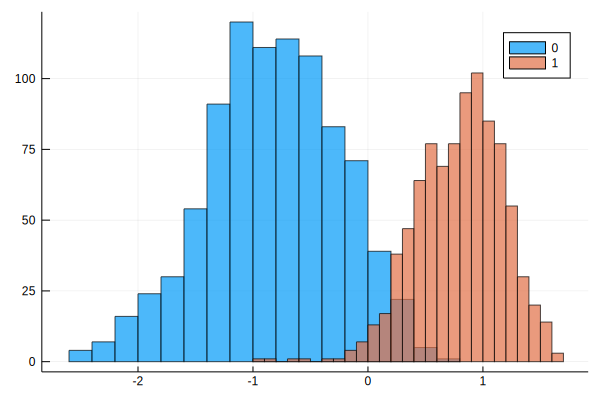

In [72]:
histogram(ytest0, alpha=0.7, label="0")
histogram!(ytest1, alpha=0.7, label="1")

### Task 4

Count the number of 0 digits that are classified correctly
using the classification rule $y < 0$ means 0 and $y > 0$ means 1.  
Calculate the *percentage* of correctly classified digits.  
Report your percentages in your report
and comment on how well (or poorly) it does.

In [77]:
# template

correct0 = [ytest0[n] < 0 for n = 1:ntest]
correct1 = [ytest1[n] > 0 for n = 1:ntest]
display("Percent 0 correct = $(sum(correct0)*100 / ntest)")
display("Percent 1 correct = $(sum(correct1)*100 / ntest)")

"Percent 0 correct = 92.55555555555556"

"Percent 1 correct = 98.11111111111111"

### Task 5
Find the digits that were misclassified and enumerate them all in your report.  
In your report, display a few of these digits. 
Comment on why you think these digits were misclassified.

In [78]:
# Find the indexes of the misclassified digits
incorrect0 = findall(ytest0 .>= 0)
incorrect1 = findall(ytest1 .<= 0)
@show(incorrect0, incorrect1);

incorrect0 = [4, 15, 51, 70, 78, 81, 95, 117, 130, 162, 169, 227, 230, 264, 271, 293, 344, 347, 362, 372, 389, 397, 404, 417, 418, 433, 434, 452, 454, 463, 477, 478, 488, 496, 500, 514, 533, 539, 560, 561, 563, 571, 572, 574, 603, 616, 619, 620, 628, 632, 633, 643, 645, 650, 652, 653, 654, 666, 701, 707, 796, 801, 822, 831, 858, 869, 872]
incorrect1 = [51, 53, 58, 215, 353, 401, 420, 554, 595, 673, 694, 704, 760, 767, 802, 815, 851]


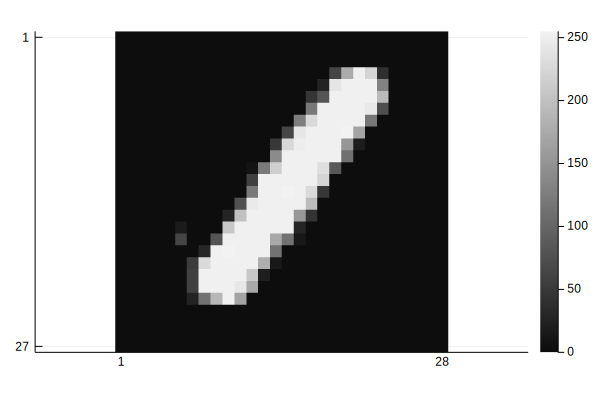

In [92]:
imshow3(cat(test1[:,:,851],dims = 3))

# Display some of the incorrectly classified digits
# Enter your code here 
imshow3(cat(test0[:,:,872],dims = 3))

In [ ]:
# Optional: show the 0 and 1 images that are the "worst" classified here
worst0 = findmax(ytest0)[2]
worst1 = findmin(ytest1)[2]
imshow3(cat(test0[:,:,worst0], test1[:,:,worst1], dims = 3))

### Optional Tasks
- Try including your own additional hand-crafted feature(s)
to see if you can improve the classification accuracy.
- Try this approach for the harder problem 4 vs 9 instead of the easier 0 vs 1.  
- Extend this notebook to handle 3 digits (do not bother trying all 10).  
- These images are $28 \times 27$ and it is hard to visualize vectors in $\mathbf{R}^{756}$. Think about how to make a 2D picture that shows the test data as a colored scatter plot with a dividing line separating (hopefully) the two classes.